In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [63]:
all_columns = ["age", "job", "marital", "education", "balance", "housing", "contact", "day", "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
bank_df = pd.read_csv("bank-full.csv", delimiter=";", usecols=all_columns)
bank_df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [64]:
bank_df["y"] = (bank_df["y"] == "yes").astype(int)

bank_df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

## splitting data

In [65]:
df_full_train, df_test = train_test_split(bank_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train.shape, df_val.shape, df_test.shape

((27126, 15), (9042, 15), (9043, 15))

## use auc for feature importance with numerical columns

In [66]:
scores = []
for col in numerical:
    auc = roc_auc_score(df_train.y, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(df_train.y, -df_train[col])
    scores.append([col, auc])

scores_df = pd.DataFrame(scores, columns=["feature", "auc"])

scores_df.sort_values(by="auc")

,feature,auc
0,age,0.512186
2,day,0.525958
4,campaign,0.571454
1,balance,0.588831
5,pdays,0.590128
6,previous,0.598565
3,duration,0.814700


# train a model

In [67]:
#extract target
y_train = df_train["y"]

#extract train to dictionary
train_dicts = df_train[categorical+numerical].to_dict(orient="records")

#onehot encode
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# train model 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## AUC for val

In [68]:
#extract target
y_val = df_val["y"]

#extract train to dictionary
val_dicts = df_val[categorical+numerical].to_dict(orient="records")

#onehot encode
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)

round(auc,3)

0.9

In [69]:
thresholds = np.linspace(0,1, 101)

actual_positive = (y_val == 1)
actual_negative =  (y_val == 0)

scores = []

for threshold in thresholds:
    
    predicted_positive = (y_pred >= threshold)
    predicted_negative =  (y_pred < threshold)
    
    tp =  sum(actual_positive & predicted_positive)
    tn =  sum(actual_negative & predicted_negative)
    
    fp = sum(actual_negative & predicted_positive)
    fn = sum(actual_positive & predicted_negative)
    
    # precision = tp / (fp + tp)
    # recall = tp / (fn + tp)

    scores.append([threshold, tp, tn, fp, fn])


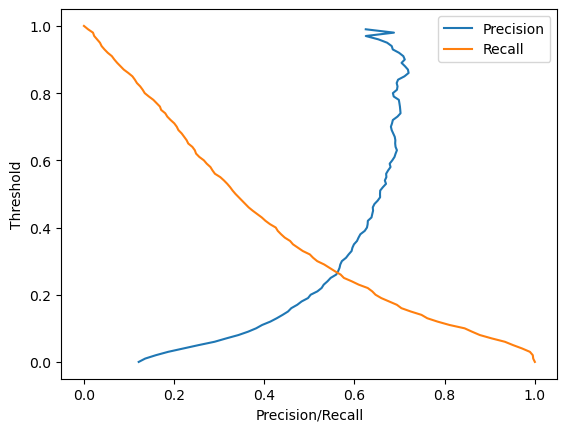

In [81]:

pr_df = pd.DataFrame(scores, columns=["threshold", "tp", "tn", "fp", "fn"])

pr_df["precision"] = pr_df.tp / (pr_df.fp + pr_df.tp)
pr_df["recall"] = pr_df.tp / (pr_df.fn + pr_df.tp)
plt.plot(pr_df["precision"], pr_df["threshold"], label="Precision")
plt.plot(pr_df["recall"], pr_df["threshold"], label="Recall")

plt.ylabel("Threshold")
plt.xlabel("Precision/Recall")
plt.legend()



In [82]:
pr_df["diff"] = np.abs(pr_df["precision"] - pr_df["recall"])

pr_df.sort_values(by="diff")

,threshold,tp,tn,fp,fn,precision,recall,diff
27,0.27,611,7471,473,487,0.563653,0.556466,0.007187
26,0.26,625,7452,492,473,0.559534,0.569217,0.009682
28,0.28,598,7487,457,500,0.566825,0.544627,0.022198
25,0.25,633,7420,524,465,0.547105,0.576503,0.029398
29,0.29,585,7500,444,513,0.568513,0.532787,0.035726
...,...,...,...,...,...,...,...,...
3,0.03,1086,3211,4733,12,0.186630,0.989071,0.802441
2,0.02,1093,2180,5764,5,0.159399,0.995446,0.836047
1,0.01,1094,986,6958,4,0.135867,0.996357,0.860490
0,0.00,1098,0,7944,0,0.121433,1.000000,0.878567


In [84]:
pr_df["f1"] = 2 * ((pr_df["precision"] * pr_df["recall"])/ (pr_df["precision"] + pr_df["recall"]))


pr_df.sort_values(by="f1", ascending=False)

,threshold,tp,tn,fp,fn,precision,recall,diff,f1
22,0.22,691,7324,620,407,0.527079,0.629326,0.102247,0.573682
21,0.21,702,7290,654,396,0.517699,0.639344,0.121645,0.572127
23,0.23,669,7355,589,429,0.531797,0.609290,0.077493,0.567912
19,0.19,724,7211,733,374,0.496911,0.659381,0.162469,0.566732
20,0.20,710,7242,702,388,0.502833,0.646630,0.143797,0.565737
...,...,...,...,...,...,...,...,...,...
96,0.96,32,7927,17,1066,0.653061,0.029144,0.623917,0.055798
97,0.97,25,7929,15,1073,0.625000,0.022769,0.602231,0.043937
98,0.98,22,7934,10,1076,0.687500,0.020036,0.667464,0.038938
99,0.99,10,7938,6,1088,0.625000,0.009107,0.615893,0.017953


In [94]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    dfk_train = df_full_train.iloc[train_idx]
    dfk_val = df_full_train.iloc[val_idx]

    train_dicts = dfk_train[categorical + numerical].to_dict(orient="records")
    val_dicts = dfk_val[categorical + numerical].to_dict(orient="records")

    y_train = dfk_train["y"]
    y_val = dfk_val["y"]
    
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:,1]

    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

np.mean(scores), np.std(scores)

(0.9059753631603789, 0.0056925827599480505)

In [96]:
for c in [0.000001, 0.001, 1]:
   
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        dfk_train = df_full_train.iloc[train_idx]
        dfk_val = df_full_train.iloc[val_idx]
    
        train_dicts = dfk_train[categorical + numerical].to_dict(orient="records")
        val_dicts = dfk_val[categorical + numerical].to_dict(orient="records")
    
        y_train = dfk_train["y"]
        y_val = dfk_val["y"]
        
        dv = DictVectorizer()
        X_train = dv.fit_transform(train_dicts)
        X_val = dv.transform(val_dicts)
    
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)
    
        y_pred = model.predict_proba(X_val)[:,1]
    
        score = roc_auc_score(y_val, y_pred)
        scores.append(score)
    
    print(c, round(np.mean(scores),3), np.std(scores))

1e-06 0.701 0.009444095099939862
0.001 0.861 0.0069448616563536816
1 0.906 0.0056925827599480505
